This notebook includes numerical experiments to find governing equations from HR data produced both odeint and solve_ivp integration methods.
To find the exact coefficients of HR model both scikit learn library and pysindy package are used for comparison.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures 
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import pysindy as ps

In [2]:
def Hindmarsh_Rose_ode(x, t, a=1., b=3., c=1., d=5., I=3., r=0.005, s=4., x_r=-1.6):
    dx = np.zeros_like(x)
    dx[0] = x[1] -a*(x[0]**3) + b*(x[0]**2) - x[2] + I
    dx[1] = c - d*(x[0]**2) - x[1]
    dx[2] = r*(s*(x[0]-x_r) - x[2])
    return dx

In [3]:
def Hindmarsh_Rose_solveivp(t, x, a=1., b=3., c=1., d=5., I=3., r=0.005, s=4., x_r=-1.6):
    dx = np.zeros_like(x)
    dx[0] = x[1] -a*(x[0]**3) + b*(x[0]**2) - x[2] + I
    dx[1] = c - d*(x[0]**2) - x[1]
    dx[2] = r*(s*(x[0]-x_r) - x[2])
    return dx

In [4]:
# integrator parameters
t_step = 0.01
t_final =2000
time = np.arange(0,t_final,t_step)

x0 = np.random.uniform(0.01, 5., 3)

In [5]:
X_sivp = solve_ivp(Hindmarsh_Rose_solveivp, [0,t_final], y0=x0, method='LSODA', t_eval=time).y.T

In [6]:
X_ode = odeint(Hindmarsh_Rose_ode, y0=x0, t=time)

In [7]:
#numerical derivatives for scikit
xdot_ode = np.gradient(X_ode, t_step, axis=0)
xdot_sivp = np.gradient(X_sivp, t_step, axis=0)

In [8]:
#transient
X_sivp = X_sivp[27000:,:]
X_ode = X_ode[27000:,:]
xdot_ode = xdot_ode[27000:,:]
xdot_sivp = xdot_sivp[27000:,:]

No handles with labels found to put in legend.


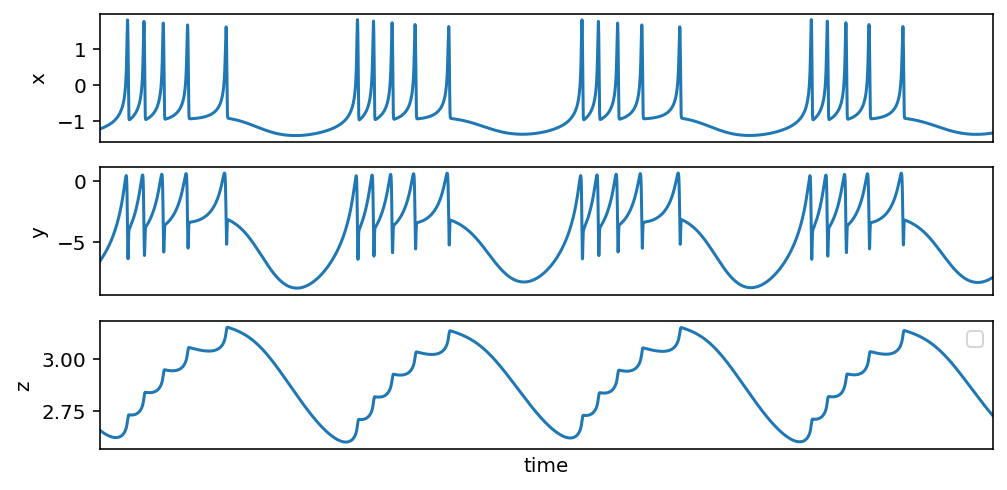

In [9]:
#some plots for comparison between integration methods
plt.figure(figsize=(8,4))
plt.subplot(311)
plt.plot(time[27000:], X_ode[:,0])
plt.xlim(1000,1600)
plt.ylabel('x')
plt.xticks([])
plt.subplot(312)
plt.plot(time[27000:], X_ode[:,1])
plt.xticks([])
plt.ylabel('y')
plt.xlim(1000,1600)
plt.subplot(313)
plt.plot(time[27000:], X_ode[:,2])
plt.ylabel('z')
plt.xlabel('time')
plt.xlim(1000,1600)
plt.xticks([])
plt.legend()

/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


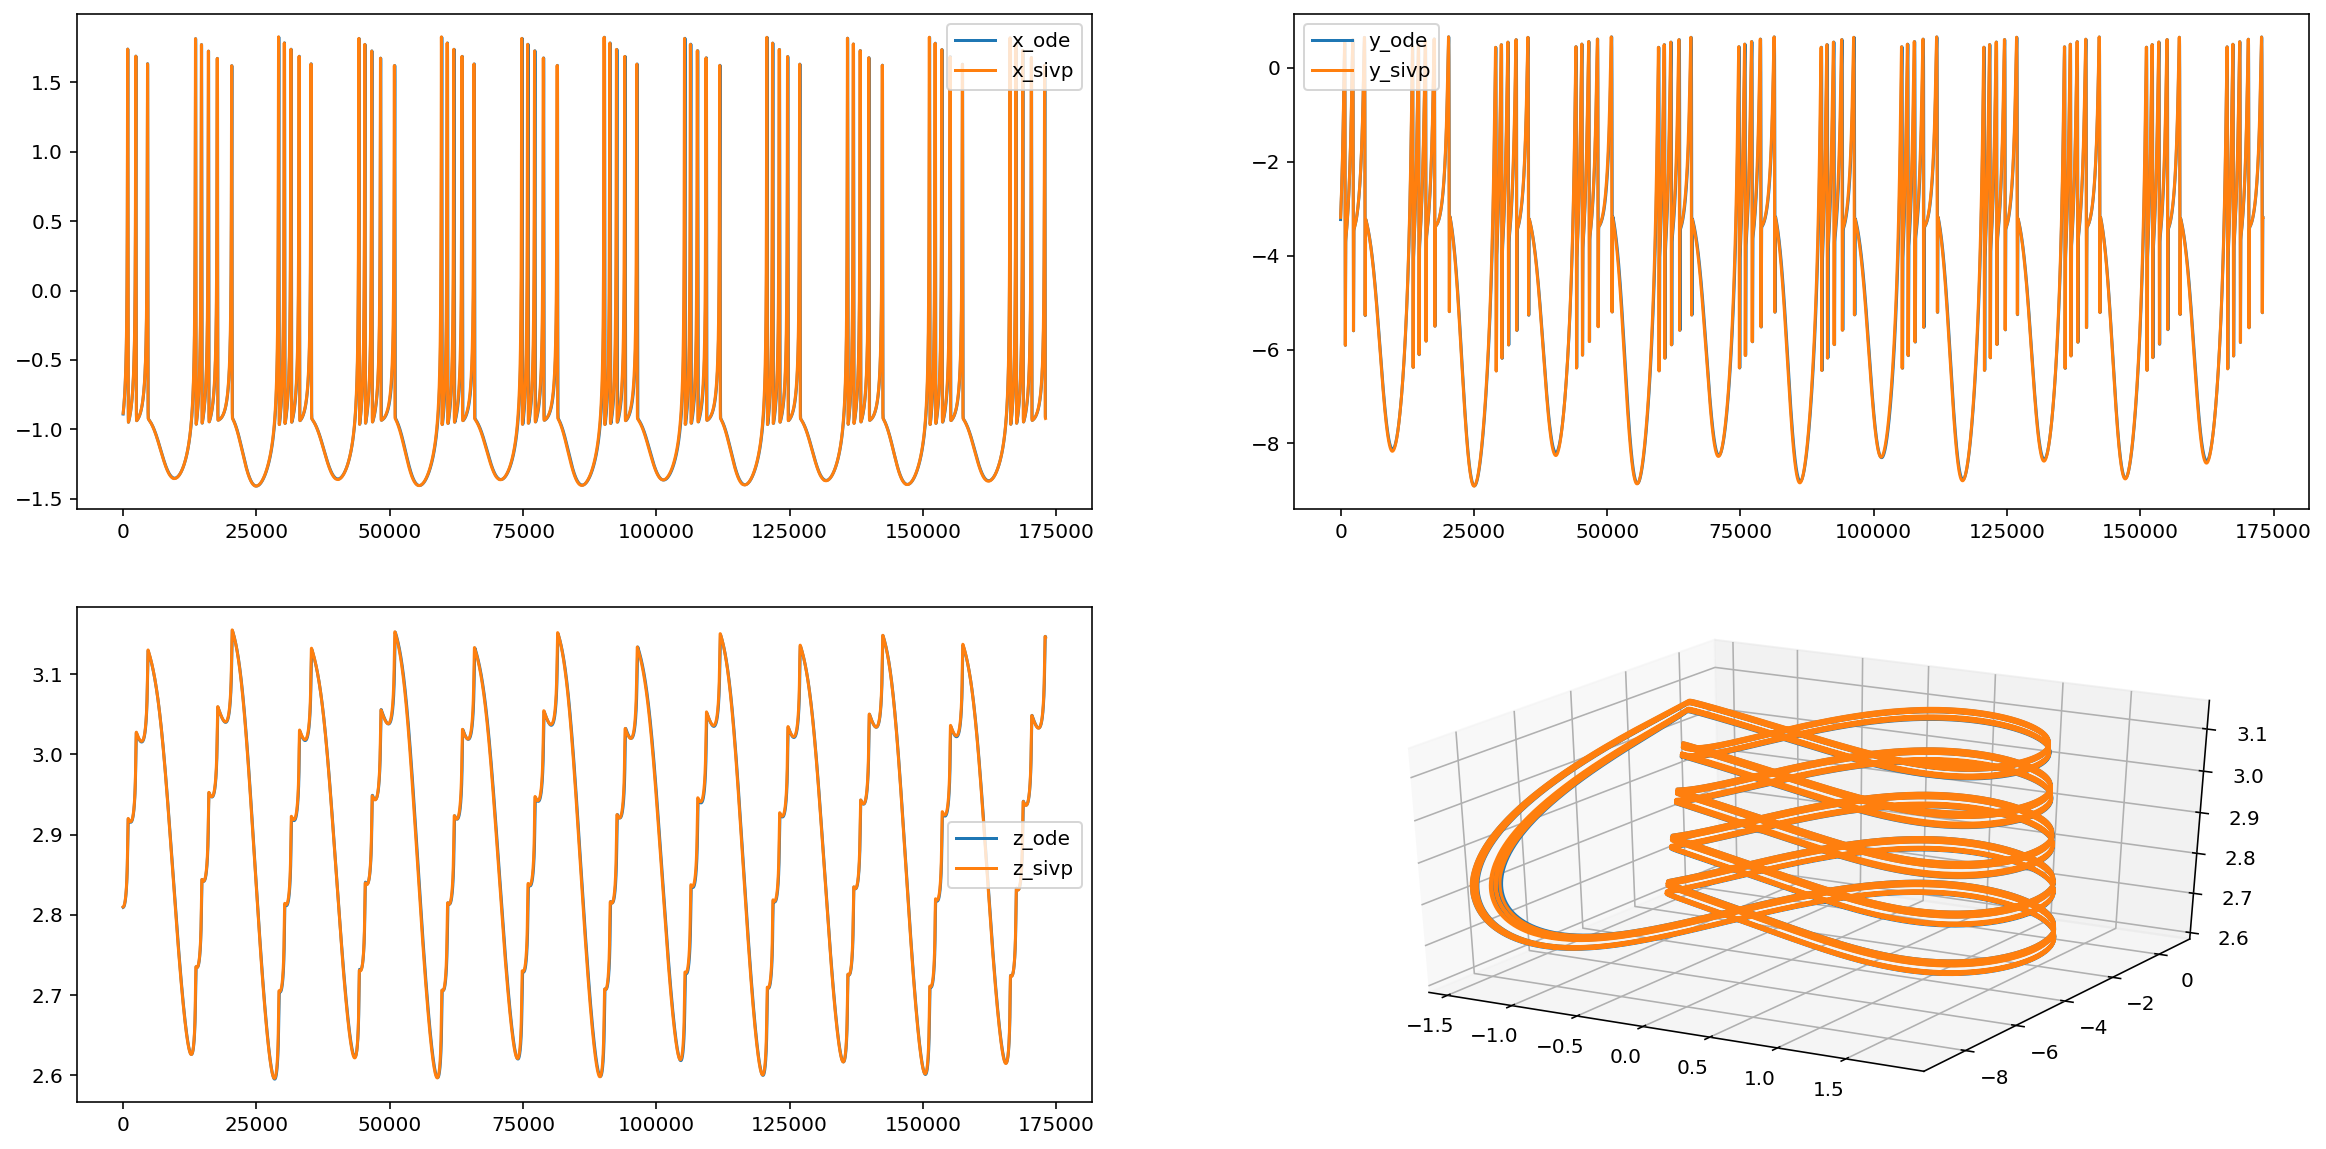

In [10]:
#some plots for comparison between integration methods
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(X_ode[:,0], label='x_ode')
plt.plot(X_sivp[:,0], label='x_sivp')
plt.legend()
plt.subplot(222)
plt.plot(X_ode[:,1], label='y_ode')
plt.plot(X_sivp[:,1], label='y_sivp')
plt.legend()
plt.subplot(223)
plt.plot(X_ode[:,2], label='z_ode')
plt.plot(X_sivp[:,2], label='z_sivp')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(X_ode[:,0], X_ode[:,1], X_ode[:,2])
plt.plot(X_sivp[:,0], X_sivp[:,1], X_sivp[:,2])

Let's see how predictions will be effected by these small differences!

### 1. Scikit_learn

In [21]:
# Non-linear function library
library = PolynomialFeatures(degree=3, include_bias=True)
# include_bias parameter is for the feature in which all polynomial powers are zero - column of ones
Theta_ode = library.fit_transform(X_ode)
Theta_sivp = library.fit_transform(X_sivp)

#### 1.1 odeint method

In [12]:
%time
threshold = 0.003
x_new = np.linalg.lstsq(Theta_ode, xdot_ode, rcond=None)[0] #initial guess 
for k in range(10):
    small_indices = np.abs(x_new) < threshold
    x_new[small_indices] = 0
    for i in range(3):
        big_indices = ~small_indices[:,i]
        x_new[big_indices,i] = np.linalg.lstsq(Theta_ode[:,big_indices], xdot_ode[:,i], rcond=None)[0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [13]:
X_ode_df = pd.DataFrame(data=x_new, columns=('x','y','z'), index=library.get_feature_names())
print('Total number of possible coefficients:', x_new.size)
print('Number of non-zero coefficients:', np.count_nonzero(x_new))

Total number of possible coefficients: 60
Number of non-zero coefficients: 11


In [14]:
X_ode_df.head(n=20)

,x,y,z
1,2.999687,0.999794,0.031999
x0,0.000000,0.000000,0.020000
x1,0.999834,-0.999794,0.000000
x2,-0.999880,0.000000,-0.005000
x0^2,2.999430,-4.998971,0.000000
x0 x1,0.000000,0.000000,0.000000
x0 x2,0.000000,0.000000,0.000000
x1^2,0.000000,0.000000,0.000000
x1 x2,0.000000,0.000000,0.000000
x2^2,0.000000,0.000000,0.000000


In [15]:
def sindy_model_predict_ode(x,t):
    dxdt = np.zeros_like(x)
    library = PolynomialFeatures(degree=3, include_bias=True)
    Theta = library.fit_transform(x.reshape(1,-1))
    dxdt = np.dot(Theta,x_new)
    return dxdt.flatten()

In [16]:
def sindy_model_predict_sivp(t,x):
    dxdt = np.zeros_like(x)
    library = PolynomialFeatures(degree=3, include_bias=True)
    Theta = library.fit_transform(x.reshape(1,-1))
    dxdt = np.dot(Theta,x_new)
    return dxdt.flatten()

In [17]:
X_predict_ode = odeint(sindy_model_predict_ode, y0=X_ode[0,:], t=time)

/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


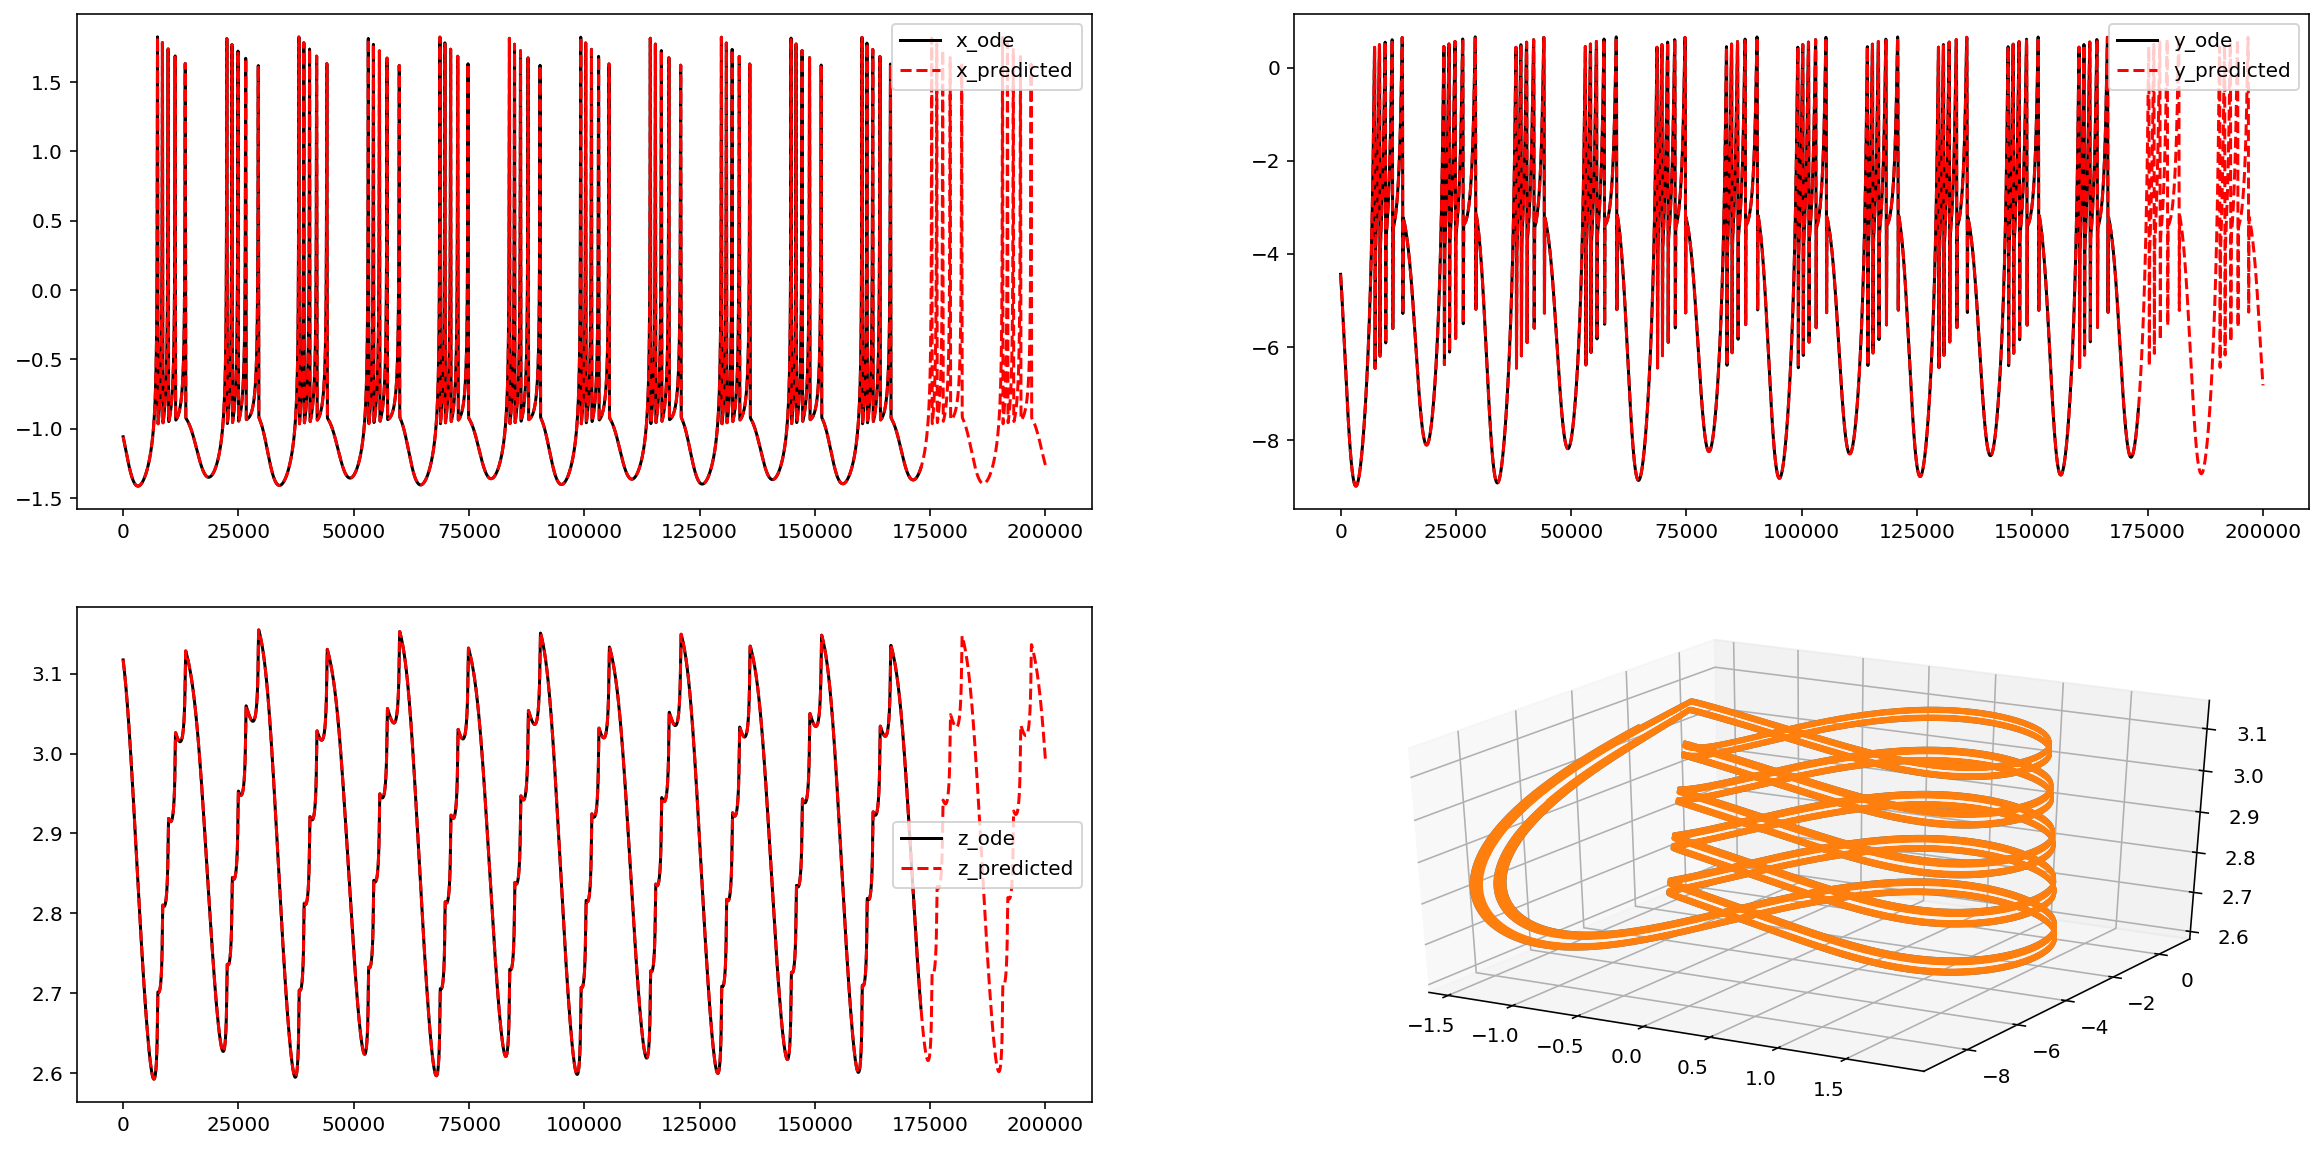

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(X_ode[:,0], 'k', label='x_ode')
plt.plot(X_predict_ode[:,0], 'r--', label='x_predicted')
plt.legend()
plt.subplot(222)
plt.plot(X_ode[:,1], 'k', label='y_ode')
plt.plot(X_predict_ode[:,1], 'r--', label='y_predicted')
plt.legend()
plt.subplot(223)
plt.plot(X_ode[:,2], 'k', label='z_ode')
plt.plot(X_predict_ode[:,2], 'r--', label='z_predicted')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(X_ode[:,0], X_ode[:,1], X_ode[:,2])
plt.plot(X_predict_ode[:,0], X_predict_ode[:,1], X_predict_ode[:,2])

#### 1.2 solve_ivp method

In [22]:
%time
threshold = 0.003
x_new = np.linalg.lstsq(Theta_sivp, xdot_sivp, rcond=None)[0] #initial guess 
for k in range(10):
    small_indices = np.abs(x_new) < threshold
    x_new[small_indices] = 0
    for i in range(3):
        big_indices = ~small_indices[:,i]
        x_new[big_indices,i] = np.linalg.lstsq(Theta_sivp[:,big_indices], xdot_sivp[:,i], rcond=None)[0]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [23]:
X_sivp_df = pd.DataFrame(data=x_new, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', x_new.size)
print('Number of non-zero coefficients:', np.count_nonzero(x_new))

Total number of possible coefficients: 60
Number of non-zero coefficients: 17


In [24]:
X_sivp_df.head(n=20)

,x0,x1,x2
1,0.446306,3.309938,0.032184
x0,0.000000,-0.005199,0.019997
x1,0.999452,-0.998038,0.000000
x2,1.658197,-2.410268,-0.005060
x0^2,2.998090,-4.994398,0.000000
x0 x1,0.000000,0.000000,0.000000
x0 x2,0.000000,0.000000,0.000000
x1^2,0.000000,0.000000,0.000000
x1 x2,0.000000,0.000000,0.000000
x2^2,-0.920760,0.837835,0.000000


In [25]:
X_predict_sivp = solve_ivp(sindy_model_predict_sivp, [0,t_final], y0=X_sivp[0,:], method='LSODA', t_eval=time).y.T

/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


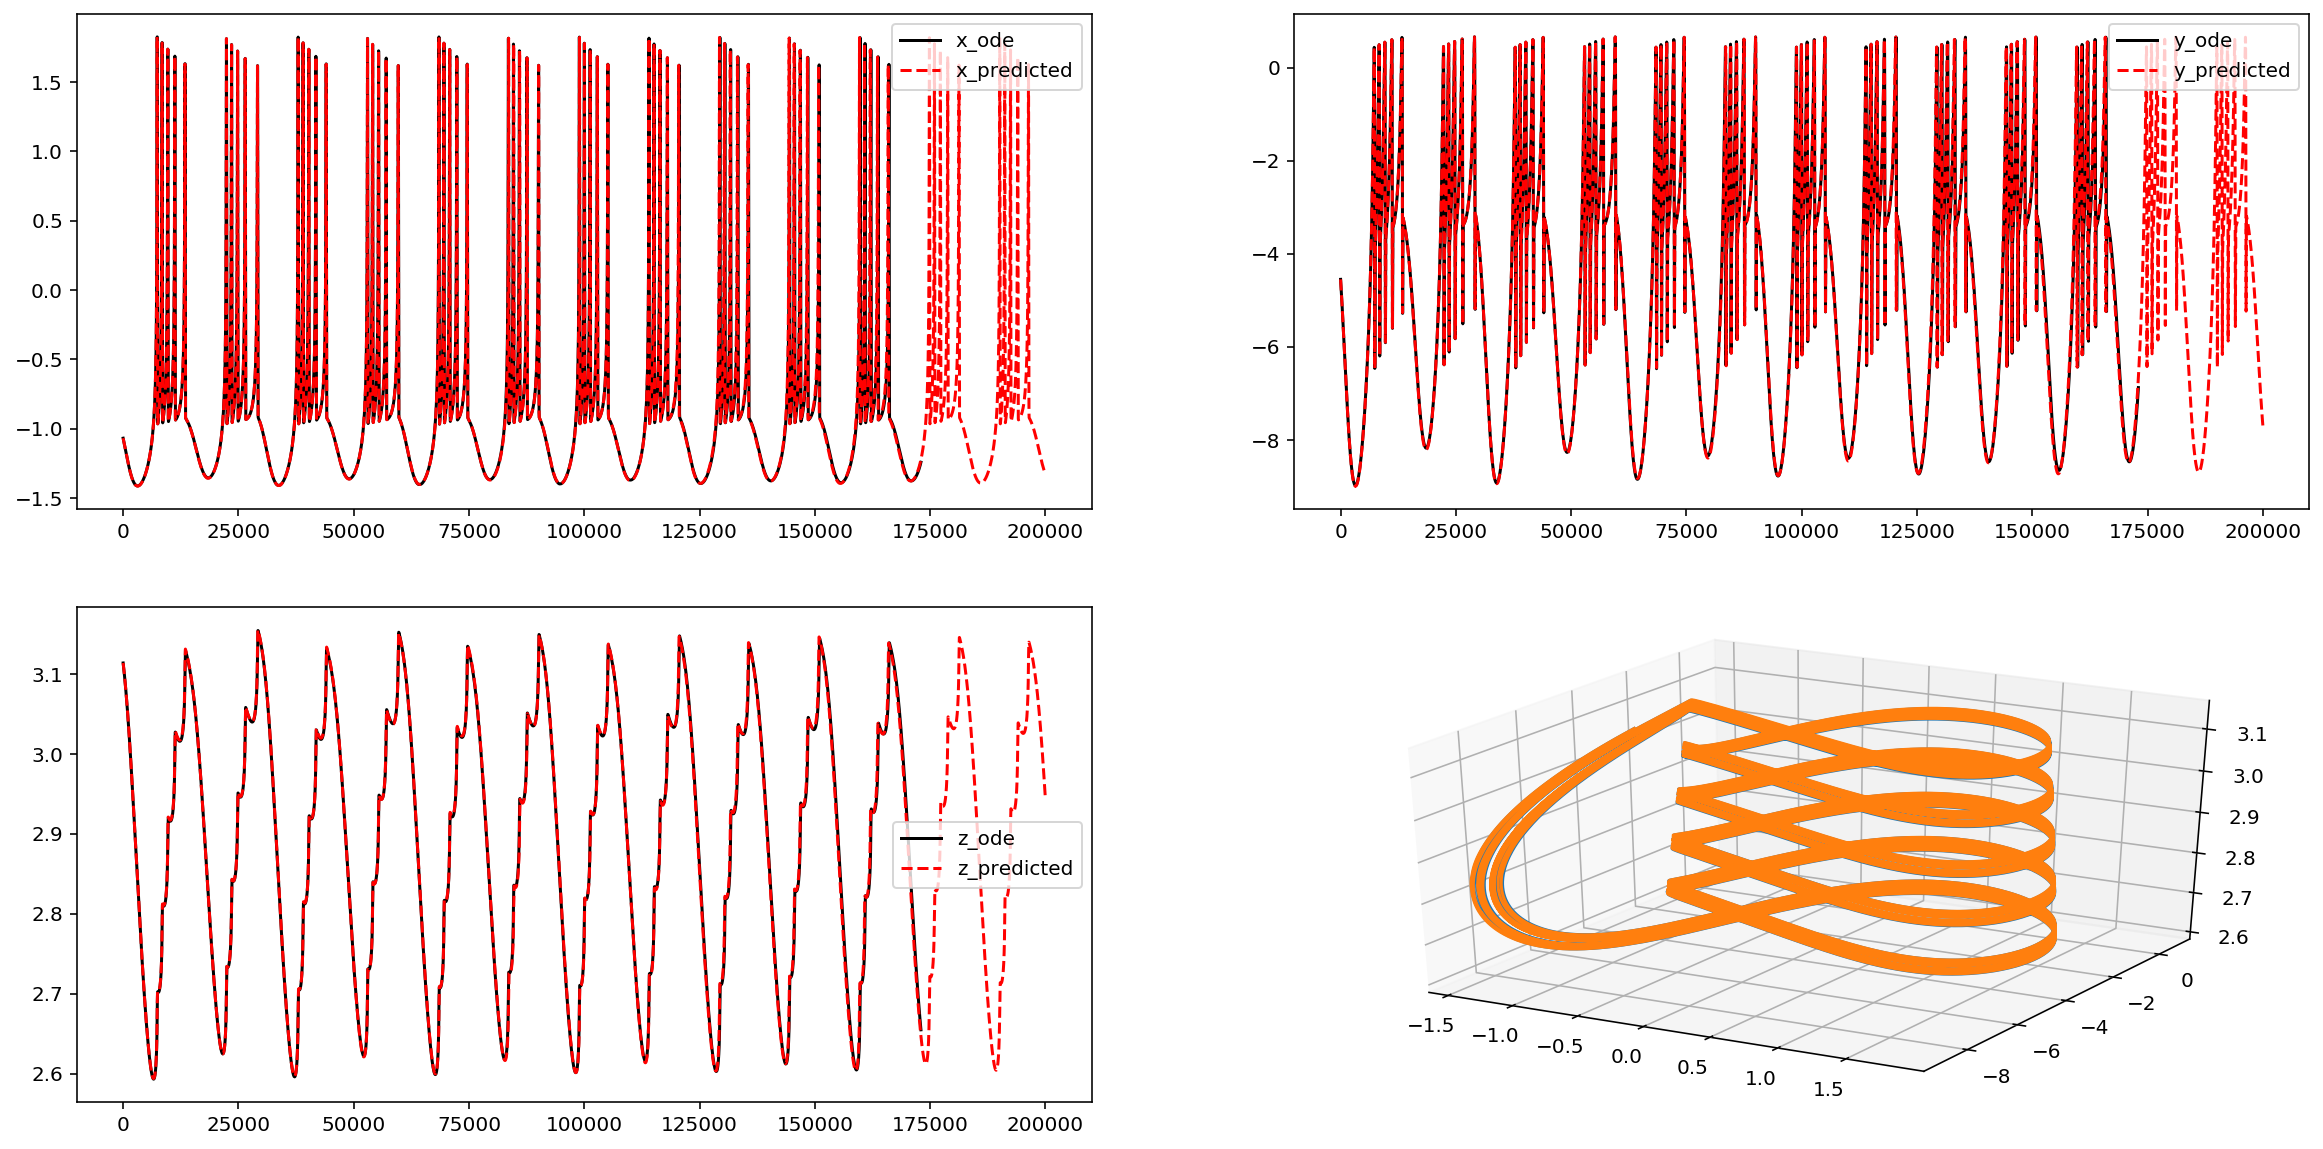

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(X_sivp[:,0], 'k', label='x_ode')
plt.plot(X_predict_sivp[:,0], 'r--', label='x_predicted')
plt.legend()
plt.subplot(222)
plt.plot(X_sivp[:,1], 'k', label='y_ode')
plt.plot(X_predict_sivp[:,1], 'r--', label='y_predicted')
plt.legend()
plt.subplot(223)
plt.plot(X_sivp[:,2], 'k', label='z_ode')
plt.plot(X_predict_sivp[:,2], 'r--', label='z_predicted')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(X_sivp[:,0], X_sivp[:,1], X_sivp[:,2])
plt.plot(X_predict_sivp[:,0], X_predict_sivp[:,1], X_predict_sivp[:,2])

### 2. pysindy 

#### 2.1. odeint method

In [11]:
sindy_optimizer = ps.STLSQ(threshold=0.003)
library_ = ps.PolynomialLibrary(degree=3, include_bias=True)
coeffs_sindy = ps.SINDy(optimizer=sindy_optimizer, feature_library=library_).fit(X_ode, t=time[27000:])
coeffs_ode = coeffs_sindy.coefficients()
coeffs_sindy.print()
X_py_ode = coeffs_sindy.simulate(X_ode[0,:], t=time)

x0' = 3.016 1 + 1.001 x1 + -1.017 x2 + 2.999 x0^2 + -0.001 x1 x2 + 0.006 x2^2 + -1.000 x0^3 + -0.001 x2^3
x1' = 1.081 1 + -1.000 x1 + -0.085 x2 + -4.999 x0^2 + 0.029 x2^2 + -0.003 x2^3
x2' = 0.032 1 + 0.020 x0 + -0.005 x2


In [13]:
df_coef = pd.DataFrame(data=coeffs_ode, columns=coeffs_sindy.get_feature_names(), index=(r'$\dot x$','$\dot y$','$\dot z$'))

In [14]:
df_coef

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2,x0^3,x0^2 x1,x0^2 x2,x0 x1^2,x0 x1 x2,x0 x2^2,x1^3,x1^2 x2,x1 x2^2,x2^3
$\dot x$,3.016418,0.00,1.000561,-1.016784,2.999427,0.0,0.0,0.0,-0.000513,0.005671,-0.999858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00009,-0.000632
$\dot y$,1.081437,0.00,-0.999791,-0.084756,-4.998963,0.0,0.0,0.0,0.000000,0.029326,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.003382
$\dot z$,0.031999,0.02,0.000000,-0.005000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000


In [17]:
print(df_coef.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &    1 &   x0 &    x1 &    x2 &  x0\textasciicircum 2 &  x0 x1 &  x0 x2 &  x1\textasciicircum 2 &  x1 x2 &  x2\textasciicircum 2 &  x0\textasciicircum 3 &  x0\textasciicircum 2 x1 &  x0\textasciicircum 2 x2 &  x0 x1\textasciicircum 2 &  x0 x1 x2 &  x0 x2\textasciicircum 2 &  x1\textasciicircum 3 &  x1\textasciicircum 2 x2 &  x1 x2\textasciicircum 2 &  x2\textasciicircum 3 \\
\midrule
\$\textbackslash dot x\$ & 3.02 & 0.00 &  1.00 & -1.02 &  3.00 &   0.00 &   0.00 &  0.00 &  -0.00 &  0.01 & -1.00 &     0.00 &     0.00 &     0.00 &      0.00 &     0.00 &  0.00 &     0.00 &     0.00 & -0.00 \\
\$\textbackslash dot y\$ & 1.08 & 0.00 & -1.00 & -0.08 & -5.00 &   0.00 &   0.00 &  0.00 &   0.00 &  0.03 &  0.00 &     0.00 &     0.00 &     0.00 &      0.00 &     0.00 &  0.00 &     0.00 &     0.00 & -0.00 \\
\$\textbackslash dot z\$ & 0.03 & 0.02 &  0.00 & -0.00 &  0.00 &   0.00 &   0.00 &  0.00 &   0.00 &  0.00 &  0.00 &     0.00 &     0.00 &   

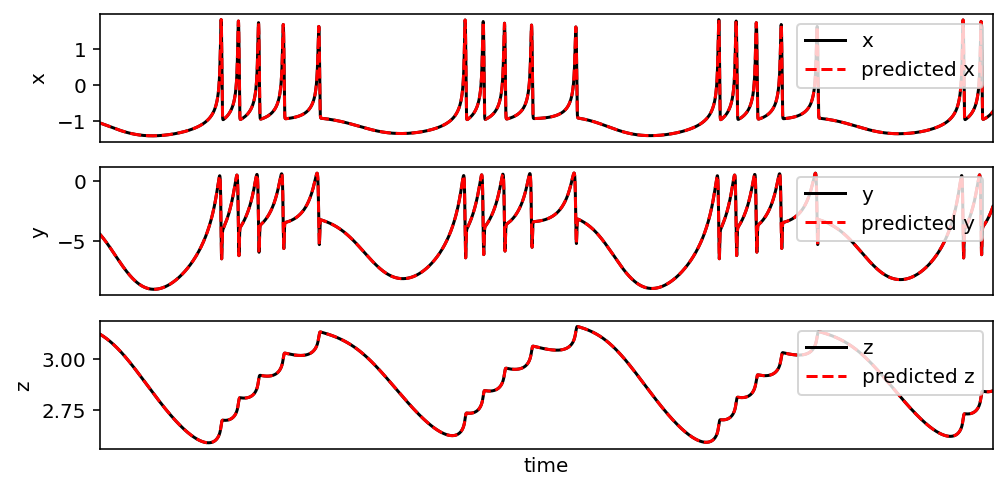

In [34]:
plt.figure(figsize=(8,4))
plt.subplot(311)
plt.plot(X_ode[:,0], 'k', label='x')
plt.plot(X_py_ode[:,0], 'r--', label='predicted x')
plt.xlim(0,55000)
plt.ylabel('x')
plt.xticks([])
plt.legend(loc=1)
plt.subplot(312)
plt.plot(X_ode[:,1], 'k', label='y')
plt.plot(X_py_ode[:,1], 'r--', label='predicted y')
plt.ylabel('y')
plt.xticks([])
plt.xlim(0,55000)
plt.legend(loc=1)
plt.subplot(313)
plt.plot(X_ode[:,2], 'k', label='z')
plt.plot(X_py_ode[:,2], 'r--', label='predicted z')
plt.ylabel('z')
plt.xlabel('time')
plt.xticks([])
plt.xlim(0,55000)
plt.legend(loc=1)

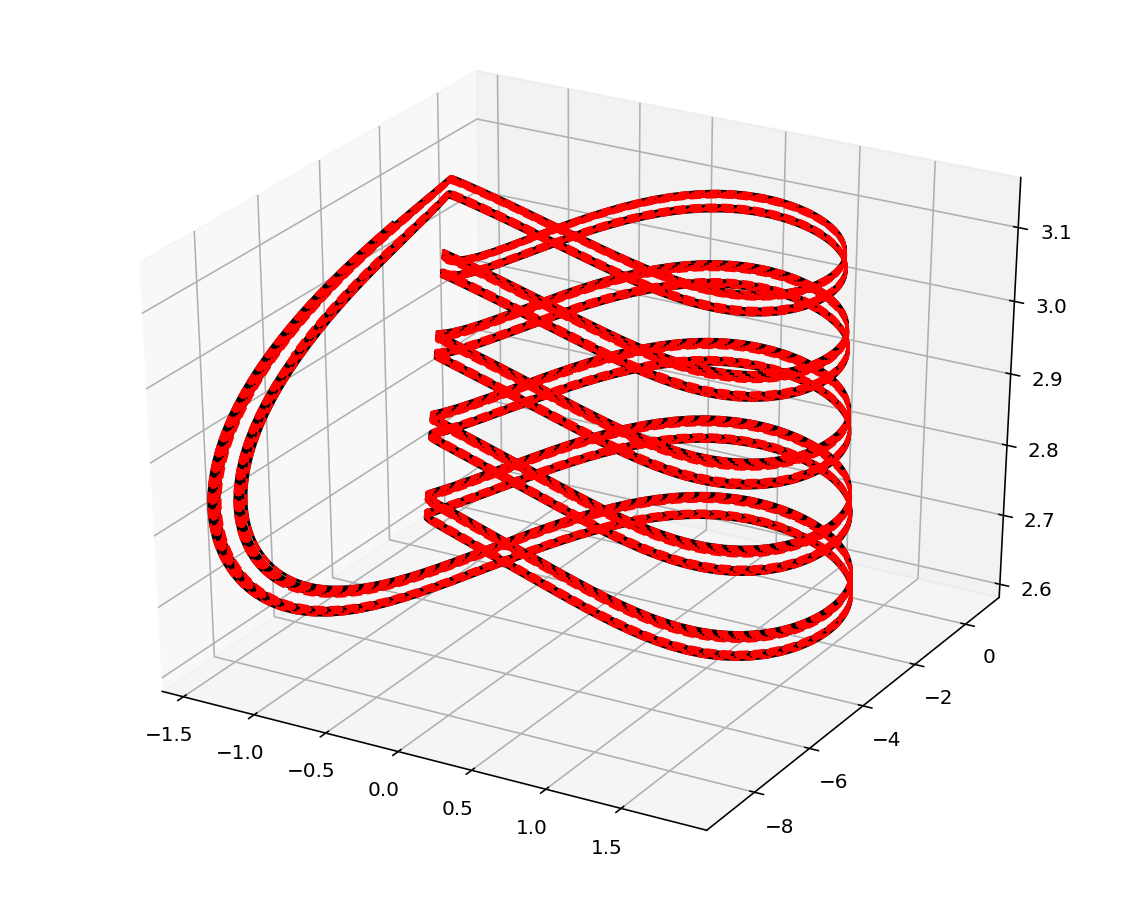

In [35]:
plt.figure(figsize=(10,8))
plt.subplot(projection='3d')
plt.plot(X_ode[:,0], X_ode[:,1], X_ode[:,2], 'k')
plt.plot(X_py_ode[:,0], X_py_ode[:,1], X_py_ode[:,2], 'r--')

#### 2.2. solve_ivp method

In [36]:
sindy_optimizer = ps.STLSQ(threshold=0.003)
library_ = ps.PolynomialLibrary(degree=3, include_bias=True)
coeffs_sindy = ps.SINDy(optimizer=sindy_optimizer, feature_library=library_).fit(X_sivp, t=time[27000:])
coeffs_sivp = coeffs_sindy.coefficients()
coeffs_sindy.print()
X_py_sivp = coeffs_sindy.simulate(X_sivp[0,:], t=time)

x0' = 0.446 1 + 0.999 x1 + 1.658 x2 + 2.998 x0^2 + -0.921 x2^2 + -0.999 x0^3 + 0.106 x2^3
x1' = 3.310 1 + -0.005 x0 + -0.998 x1 + -2.410 x2 + -4.994 x0^2 + 0.838 x2^2 + -0.097 x2^3
x2' = 0.032 1 + 0.020 x0 + -0.005 x2


/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


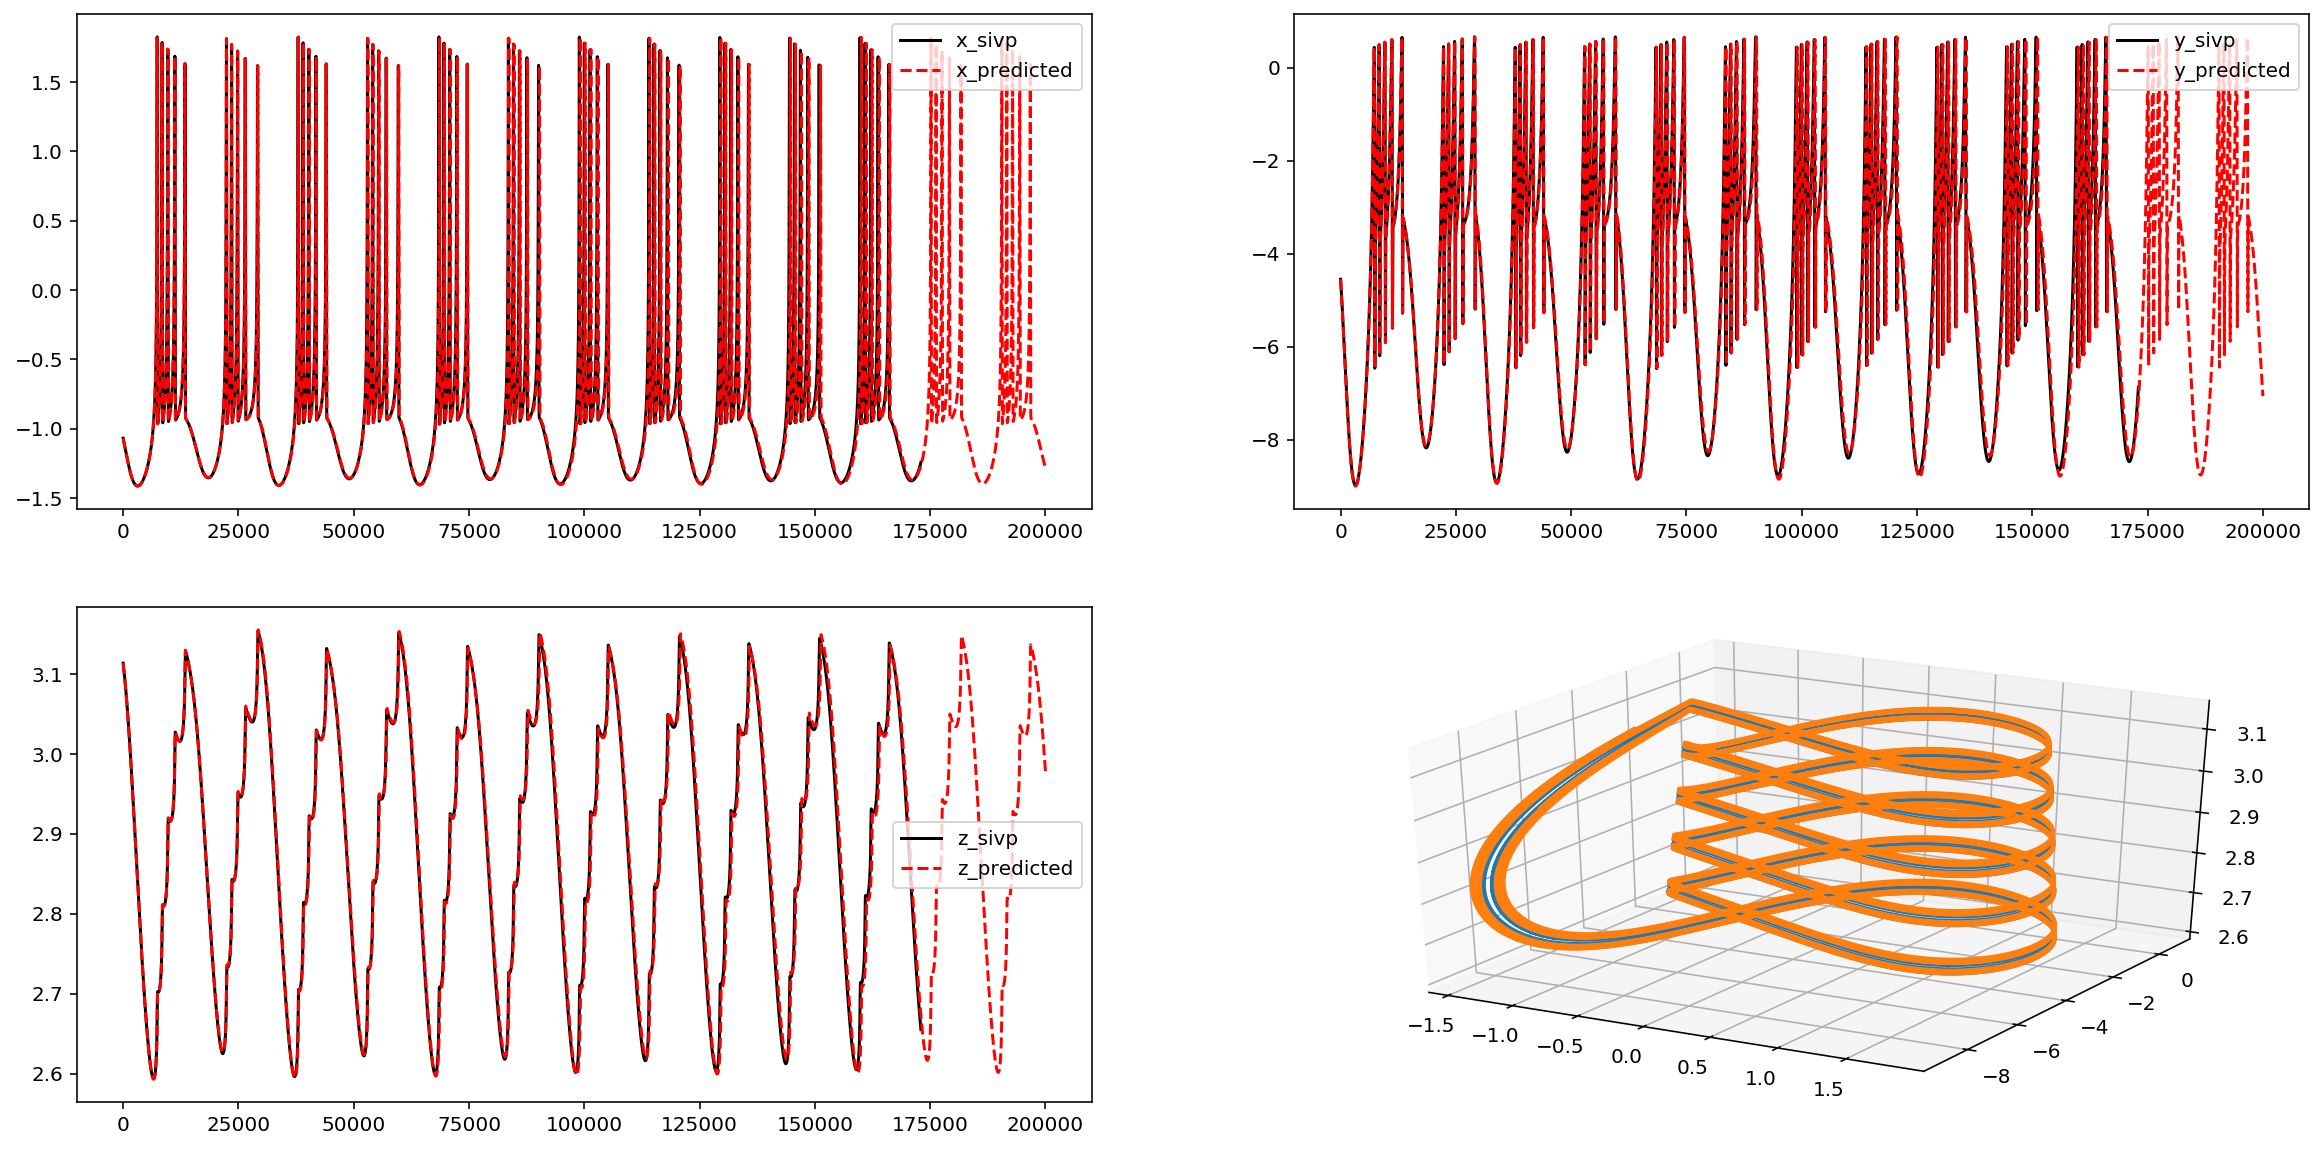

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(X_sivp[:,0], 'k', label='x_sivp')
plt.plot(X_py_sivp[:,0], 'r--', label='x_predicted')
plt.legend()
plt.subplot(222)
plt.plot(X_sivp[:,1], 'k', label='y_sivp')
plt.plot(X_py_sivp[:,1], 'r--', label='y_predicted')
plt.legend()
plt.subplot(223)
plt.plot(X_sivp[:,2], 'k', label='z_sivp')
plt.plot(X_py_sivp[:,2], 'r--', label='z_predicted')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(X_sivp[:,0], X_sivp[:,1], X_sivp[:,2])
plt.plot(X_py_sivp[:,0], X_py_sivp[:,1], X_py_sivp[:,2])